In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud as WC
from PIL import Image
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
def hashtags(text):
    re_hash = re.compile("#\S+")
    result = re_hash.findall(text)
    if result:
        return ", ".join(result)
    return result.append("None")

def remove_url(text):
    re_url = re.compile("https+://\S+|www\.\S+")
    return re_url.sub("", text)

def stemmer(text):
    stemmer = SnowballStemmer("english")

    wordlist = word_tokenize(text)

    words = [stemmer.stem(word) for word in wordlist]

    return " ".join(words)

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df["keyword"] = df["keyword"].str.replace("%20", " ")
df["keyword"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
7608    NaN
7609    NaN
7610    NaN
7611    NaN
7612    NaN
Name: keyword, Length: 7613, dtype: object

In [9]:
mode_keyword = df['keyword'].mode().values[0]
mode_keyword

'fatalities'

In [10]:
df["keyword"].fillna(mode_keyword, inplace=True)

In [11]:
df.drop("location", axis=1, inplace=True)

In [12]:
df.head()

,id,keyword,text,target
0,1,fatalities,Our Deeds are the Reason of this #earthquake M...,1
1,4,fatalities,Forest fire near La Ronge Sask. Canada,1
2,5,fatalities,All residents asked to 'shelter in place' are ...,1
3,6,fatalities,"13,000 people receive #wildfires evacuation or...",1
4,7,fatalities,Just got sent this photo from Ruby #Alaska as ...,1


In [13]:
df.set_index("id", drop=True, inplace=True)

In [14]:
df["text"] = df["text"].str.lower()

In [15]:
df["text"] = df["text"].apply(remove_url)

In [16]:
df["hashtags"] = df["text"].apply(hashtags)

In [17]:
df.head()

,keyword,text,target,hashtags
id,,,,
1,fatalities,our deeds are the reason of this #earthquake m...,1,#earthquake
4,fatalities,forest fire near la ronge sask. canada,1,None
5,fatalities,all residents asked to 'shelter in place' are ...,1,None
6,fatalities,"13,000 people receive #wildfires evacuation or...",1,#wildfires
7,fatalities,just got sent this photo from ruby #alaska as ...,1,"#alaska, #wildfires"


In [18]:
stopwords = stopwords.words('english')

In [19]:
df["text"] = df["text"].apply(stemmer)

In [20]:
df.head()

,keyword,text,target,hashtags
id,,,,
1,fatalities,our deed are the reason of this # earthquak ma...,1,#earthquake
4,fatalities,forest fire near la rong sask . canada,1,None
5,fatalities,all resid ask to shelter in place ' are be not...,1,None
6,fatalities,"13,000 peopl receiv # wildfir evacu order in c...",1,#wildfires
7,fatalities,just got sent this photo from rubi # alaska as...,1,"#alaska, #wildfires"


In [21]:
df["text"] = df["text"].str.replace(r"[^\w\s]+", " ")

/tmp/ipykernel_4195/1504787646.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["text"] = df["text"].str.replace(r"[^\w\s]+", " ")


In [22]:
df["hashtags"] = df["hashtags"].str.replace(r"[#,]", "")

/tmp/ipykernel_4195/91379541.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df["hashtags"] = df["hashtags"].str.replace(r"[#,]", "")


In [23]:
df.head()

,keyword,text,target,hashtags
id,,,,
1,fatalities,our deed are the reason of this earthquak ma...,1,earthquake
4,fatalities,forest fire near la rong sask canada,1,None
5,fatalities,all resid ask to shelter in place are be not...,1,None
6,fatalities,13 000 peopl receiv wildfir evacu order in c...,1,wildfires
7,fatalities,just got sent this photo from rubi alaska as...,1,alaska wildfires


In [24]:
disaster_df = df[df["target"] == 1]

In [25]:
wordcloud = WC(
  width=800, height=800,
  max_words=3000,
  colormap="Accent"
).generate(" ".join(disaster_df["text"].str.upper().tolist()))

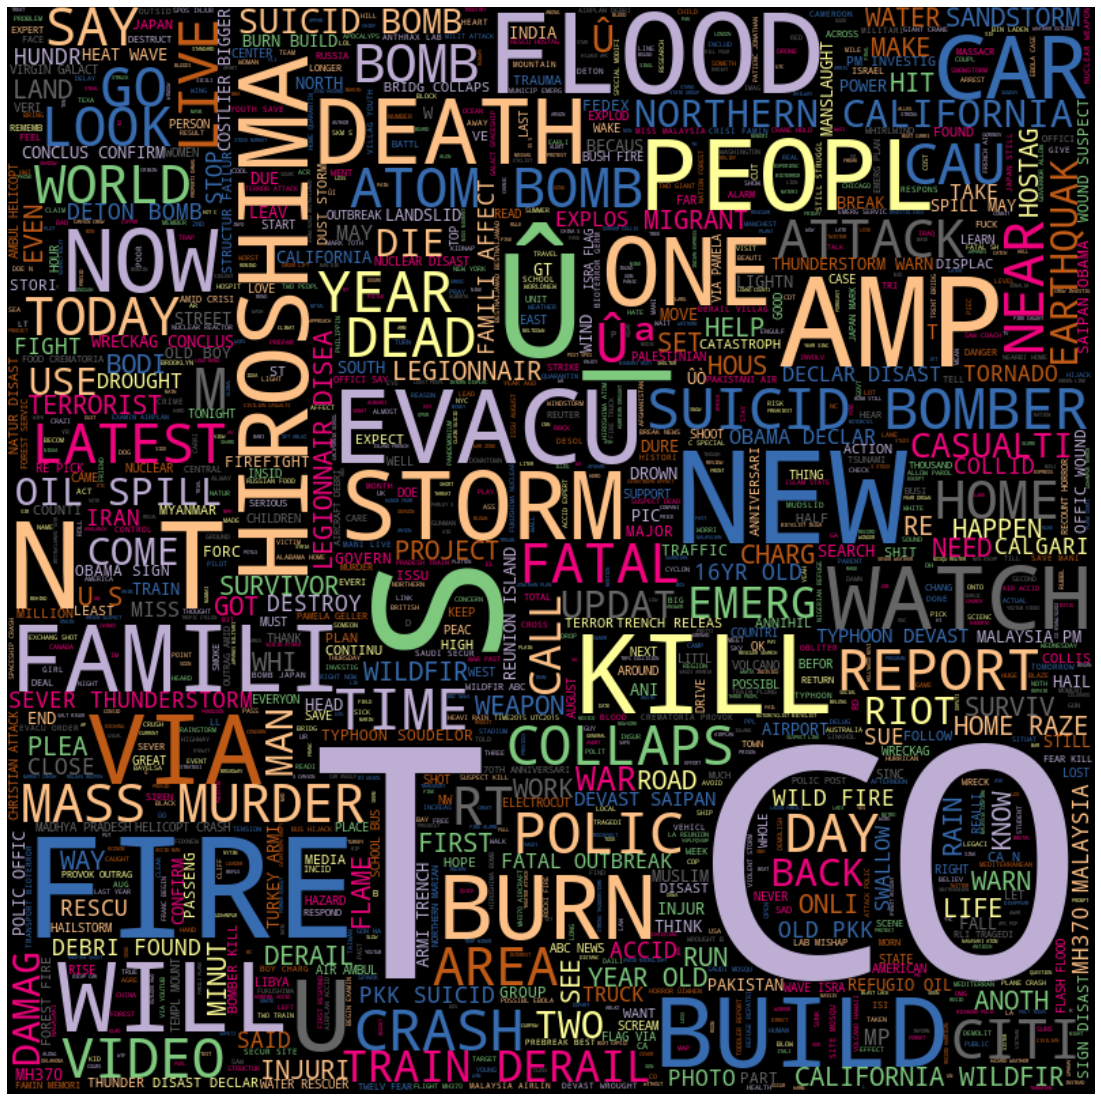

In [26]:
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(wordcloud, interpolation="bilinear")

In [27]:
X = df["text"]
y = df["target"]

In [28]:
vec = TfidfVectorizer(
  stop_words="english",
  max_features=20000,
  lowercase=True,
  # analyzer="char_wb"
)

In [29]:
X_trans = vec.fit_transform(X).toarray()

In [30]:
X_df = pd.DataFrame(
  X_trans, columns=vec.get_feature_names_out()
)

In [31]:
X_df

,00,000,0000,007npen6lg,00cy9vxeff,00end,00pm,01,02,0215,...,ûò,ûò800000,ûòthe,ûòåêcnbc,ûó,ûóher,ûókodi,ûóneglig,ûótech,ûów
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.458131,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.308018,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelling

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
  X_df, y, test_size=0.2, random_state=404
)

### Multinomial Naive Bayes Model

**Declaring Model**

In [33]:
model = MultinomialNB()

**Fitting model**

In [34]:
model.fit(X_train, y_train)

MultinomialNB()

**Making predictions with model**

In [35]:
pred = model.predict(X_test)

**Checking Performance Metrics**

In [36]:
accuracy = accuracy_score(y_test, pred)

In [37]:
precision = precision_score(y_test, pred)

In [38]:
f1 = f1_score(y_test, pred)

### Logistic Regression Model

**Declaring Model**

In [39]:
logReg = LogisticRegression(
    random_state = 42
)

**Fitting Model with data**

In [40]:
logReg.fit(X_train, y_train)

LogisticRegression(random_state=42)

**Making Predictions**

In [41]:
logReg_pred = logReg.predict(X_test)

**Metrics**

In [42]:
accuracy_score(y_test, logReg_pred)

0.8030203545633617

In [43]:
precision_score(y_test, logReg_pred)

0.843298969072165

In [44]:
f1_score(y_test, logReg_pred)

0.7316636851520572

## Conclusion


In [45]:
multinomial_nb = {
    'Accuracy': accuracy,
    "Precision": precision,
    "F1_score" : f1
}
Log = {
    'Accuracy': accuracy_score(y_test, logReg_pred),
    "Precision": precision_score(y_test, logReg_pred),
    "F1_score" : f1_score(y_test, logReg_pred)
}

In [46]:
pd.DataFrame(
    [multinomial_nb, Log], columns=["Accuracy", "Precision", "f1_score"],
    index=["Multinomial Naive Bayes", "Logistic Regression"]
)

,Accuracy,Precision,f1_score
Multinomial Naive Bayes,0.799081,0.844211,NaN
Logistic Regression,0.803020,0.843299,NaN


**We can therefore conclude that Logistic Regression is a better model to use for classify disaster tweets.**